Code from https://towardsdatascience.com/handwritten-digit-mnist-pytorch-977b5338e627

Rest from Erik Connerty
September 6th, 2023

### Imports

In [2]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

### Define the Transform

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

### Download the MNIST dataset

In [4]:
#We have a test set and a training set
trainset = datasets.MNIST('./data', download=True, train=True, transform=transform)
valset = datasets.MNIST('./data', download=True, train=False, transform=transform)

### Loads the data in a batch of 64 images

In [5]:

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

### Get a batch from the dataset and print its outputs and shape

In [6]:
images, labels = next(iter(trainloader))

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


### Display images

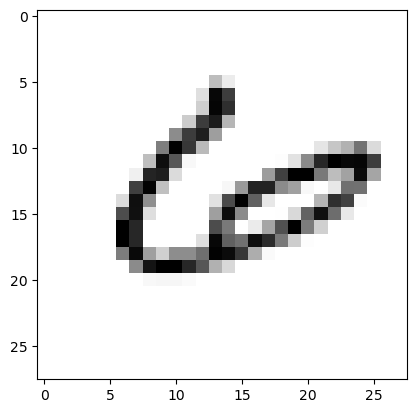

In [7]:
#Display one image
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')
plt.show()

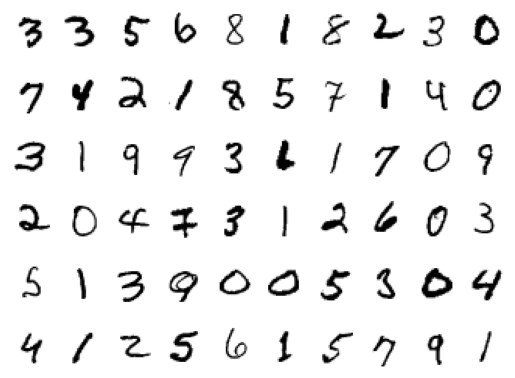

In [8]:
#Display more of the images
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')
#plt.show()

### Define the model architecture

In [9]:
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)


### Define the loss function

In [10]:
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss

### Do a pass and update the weights with the gradient

In [11]:
print('Before backward pass: \n', model[0].weight.grad)
loss.backward()
print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[-1.1627e-03, -1.1627e-03, -1.1627e-03,  ..., -1.1627e-03,
         -1.1627e-03, -1.1627e-03],
        [ 8.5714e-05,  8.5714e-05,  8.5714e-05,  ...,  8.5714e-05,
          8.5714e-05,  8.5714e-05],
        [ 9.3700e-05,  9.3700e-05,  9.3700e-05,  ...,  9.3700e-05,
          9.3700e-05,  9.3700e-05],
        ...,
        [-1.3518e-03, -1.3518e-03, -1.3518e-03,  ..., -1.3518e-03,
         -1.3518e-03, -1.3518e-03],
        [-4.7606e-04, -4.7606e-04, -4.7606e-04,  ..., -4.7606e-04,
         -4.7606e-04, -4.7606e-04],
        [ 2.0154e-03,  2.0154e-03,  2.0154e-03,  ...,  2.0154e-03,
          2.0154e-03,  2.0154e-03]])


### Train the model with stochastic gradient descent

In [12]:
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
time0 = time()
epochs = 15
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
print("\nTraining Time (in minutes) =",(time()-time0)/60)


Epoch 0 - Training loss: 0.6244131839002119
Epoch 1 - Training loss: 0.28577446511019267
Epoch 2 - Training loss: 0.22242214959631088
Epoch 3 - Training loss: 0.17742162710154996
Epoch 4 - Training loss: 0.14705969833099702
Epoch 5 - Training loss: 0.12508357652544436
Epoch 6 - Training loss: 0.1094124717876188
Epoch 7 - Training loss: 0.09754827698029435
Epoch 8 - Training loss: 0.08799162864693001
Epoch 9 - Training loss: 0.07854385856640285
Epoch 10 - Training loss: 0.07075874901948564
Epoch 11 - Training loss: 0.06713794549651095
Epoch 12 - Training loss: 0.060781603012837644
Epoch 13 - Training loss: 0.05701795087974352
Epoch 14 - Training loss: 0.050933534503112166

Training Time (in minutes) = 0.8239590366681416


### Test the model

In [13]:
correct_count, all_count = 0, 0
for images,labels in valloader:
  for i in range(len(labels)):
    img = images[i].view(1, 784)
    with torch.no_grad():
        logps = model(img)

    
    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.976


### Generate a figure to show the test accuracy

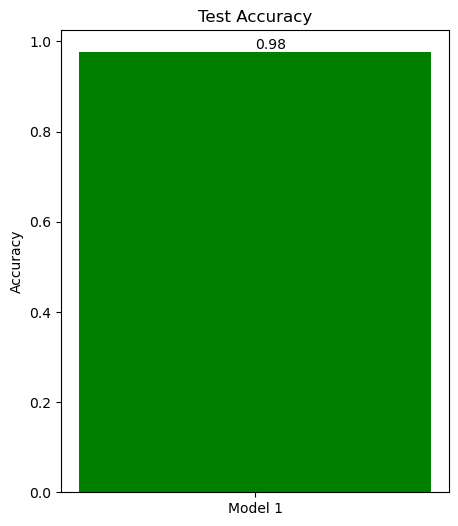

In [14]:
# Test accuracy
test_accuracy = correct_count / all_count  # You already have this value

# Labels and values for the bar chart
labels = ['Model 1']
values = [test_accuracy]

# Generate bar chart
plt.figure(figsize=(5, 6))
bars = plt.bar(labels, values, color=['green'])

# Add value annotations on the bar
yval = bars[0].get_height()
plt.text(bars[0].get_x() + bars[0].get_width()/2.0, yval, round(yval, 2), va='bottom')  # va: vertical alignment


# Add axis labels and title
#plt.xlabel('Model 1')
plt.ylabel('Accuracy')
plt.title('Test Accuracy')

# Save as SVG
plt.savefig('Test_Accuracy1.pdf', format='pdf')

# Show the plot
plt.show()

### Create another model with more hidden layer parameters

In [15]:
input_size2 = 784
hidden_sizes2 = [256, 128]
output_size2 = 10

model2 = nn.Sequential(nn.Linear(input_size2, hidden_sizes2[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes2[0], hidden_sizes2[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes2[1], output_size2),
                      nn.LogSoftmax(dim=1))
print(model2)

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)


### Train model 2 

In [16]:
optimizer = optim.SGD(model2.parameters(), lr=0.003, momentum=0.9)
time0 = time()
epochs = 15
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # Training pass
        optimizer.zero_grad()
        
        output = model2(images)
        loss = criterion(output, labels)
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 0 - Training loss: 0.637008592081286
Epoch 1 - Training loss: 0.2771649731756019
Epoch 2 - Training loss: 0.21548340143536582
Epoch 3 - Training loss: 0.17057482255841178
Epoch 4 - Training loss: 0.13922972637993186
Epoch 5 - Training loss: 0.11795828125473343
Epoch 6 - Training loss: 0.10253852507028022
Epoch 7 - Training loss: 0.0887419300834968
Epoch 8 - Training loss: 0.07959114777337291
Epoch 9 - Training loss: 0.07084927312594884
Epoch 10 - Training loss: 0.06344595285100756
Epoch 11 - Training loss: 0.05682359477366084
Epoch 12 - Training loss: 0.053207946646867246
Epoch 13 - Training loss: 0.046359609634027694
Epoch 14 - Training loss: 0.04376179362257033

Training Time (in minutes) = 0.8582654356956482


### Test the 2nd model

In [17]:
correct_count2, all_count2 = 0, 0
for images,labels in valloader:
  for i in range(len(labels)):
    img = images[i].view(1, 784)
    with torch.no_grad():
        logps = model2(img)

    
    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count2 += 1
    all_count2 += 1

print("Number Of Images Tested =", all_count2)
print("\nModel Accuracy =", (correct_count2/all_count2))

Number Of Images Tested = 10000

Model Accuracy = 0.9783


### Plot the accuracy of both models

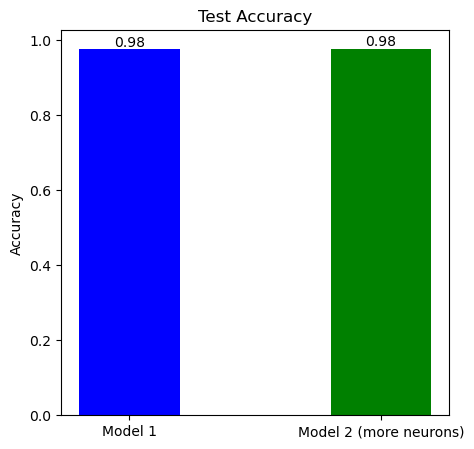

In [18]:
# Test accuracies
test_accuracy1 = correct_count / all_count  # Accuracy for the first model
test_accuracy2 = correct_count2 / all_count2  # Accuracy for the second model

# Labels and values for the bar chart
labels = ['Model 1', 'Model 2 (more neurons)']
values = [test_accuracy1, test_accuracy2]

# Generate bar chart
plt.figure(figsize=(5, 5))

# Position of bars on x-axis
ind = np.arange(len(labels))

# Width of a bar
width = 0.4  

# Plotting
plt.bar(ind, values, width, label='Test Accuracy', color=['blue', 'green'])

# Add value annotations on each bar
for i, v in enumerate(values):
    plt.text(i, v, "{:.2f}".format(v), ha='center', va='bottom')

# Add axis labels, title, and legend
plt.ylabel('Accuracy')
plt.title('Test Accuracy')
plt.xticks(ind, labels)

# Save as SVG
plt.savefig('Test_Accuracy_Comparison.pdf', format='pdf')

# Show the plot
plt.show()
